<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [61]:
import os
import zipfile
import kagglehub
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from torchvision.datasets import ImageFolder
from sklearn.manifold import TSNE
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.nn.utils import spectral_norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
def get_dataloader(image_size, batch_size, dataset_path="/kaggle/input/faces-dataset-small"):
    transform = tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    dataset = ImageFolder(root=dataset_path, transform=transform)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    return dataloader

In [6]:
path = kagglehub.dataset_download("tommykamaz/faces-dataset-small")

image_size = 128
batch_size = 64
dataloader = get_dataloader(image_size, batch_size, dataset_path=path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [29]:
class Generator(nn.Module):
    def __init__(self, latent_size, img_channels=3, img_size=128):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(
            nn.Linear(latent_size, 128 * self.init_size**2),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z.view(z.size(0), -1))
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_channels=3, img_size=128):
        super(Discriminator, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1))

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters))
            block.extend([
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.25)
            ])
            return block

        self.model = nn.Sequential(
            *discriminator_block(img_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = img_size // 2**4
        self.adv_layer = nn.Sequential(
            nn.Linear(128 * ds_size**2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.size(0), -1)
        validity = self.adv_layer(out)
        return validity

In [30]:
latent_size = 100
image_size = 128

generator = Generator(latent_size, img_size=image_size).to(device)
discriminator = Discriminator(img_size=image_size).to(device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [39]:
lr = 0.0001
epochs = 10

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
    "discriminator": optim.Adam(model["discriminator"].parameters(), lr=0.00005, betas=(0.5, 0.999)),
    "generator": optim.Adam(model["generator"].parameters(), lr=0.0001, betas=(0.5, 0.999))
}

In [40]:
def fit(model, criterion, epochs, lr):
    G_losses = []
    D_losses = []

    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            real_labels = torch.FloatTensor(batch_size, 1).uniform_(0.9, 1.0).to(device)
            fake_labels = torch.FloatTensor(batch_size, 1).uniform_(0.0, 0.1).to(device)

            # обучение дискриминатора
            model["discriminator"].zero_grad()

            outputs_real = model["discriminator"](real_images)
            d_loss_real = criterion["discriminator"](outputs_real, real_labels)

            noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](noise)
            outputs_fake = model["discriminator"](fake_images.detach())
            d_loss_fake = criterion["discriminator"](outputs_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer["discriminator"].step()

            # обучение генератора
            model["generator"].zero_grad()

            noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](noise)
            outputs = model["discriminator"](fake_images)
            g_loss = criterion["generator"](outputs, real_labels)

            g_loss.backward()
            optimizer["generator"].step()

            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())

            if i % 50 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{i}/{len(dataloader)}], '
                      f'D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')

        with torch.no_grad():
            test_noise = torch.randn(1, latent_size, 1, 1, device=device)
            generated = model["generator"](test_noise).cpu()
            save_image(generated*0.5+0.5, f'generated_{epoch}.png')

    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return G_losses, D_losses


Epoch [1/10], Batch [0/50], D_loss: 1.3042, G_loss: 0.7419
Epoch [2/10], Batch [0/50], D_loss: 1.2899, G_loss: 0.8333
Epoch [3/10], Batch [0/50], D_loss: 1.2988, G_loss: 0.8914
Epoch [4/10], Batch [0/50], D_loss: 1.3085, G_loss: 0.7911
Epoch [5/10], Batch [0/50], D_loss: 1.4910, G_loss: 0.8718
Epoch [6/10], Batch [0/50], D_loss: 1.2809, G_loss: 0.7751
Epoch [7/10], Batch [0/50], D_loss: 1.3318, G_loss: 0.8336
Epoch [8/10], Batch [0/50], D_loss: 1.2980, G_loss: 0.8581
Epoch [9/10], Batch [0/50], D_loss: 1.2170, G_loss: 0.9238
Epoch [10/10], Batch [0/50], D_loss: 1.2861, G_loss: 0.8926


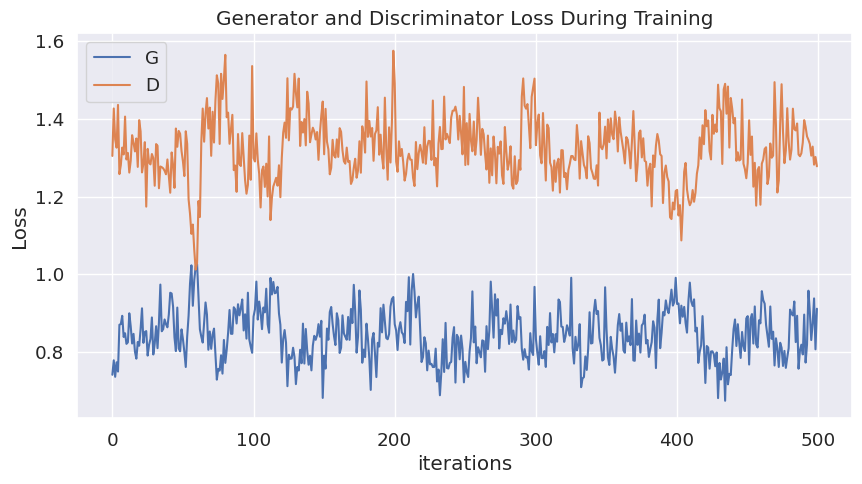

In [42]:
G_losses, D_losses = fit(model, criterion, epochs, lr)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

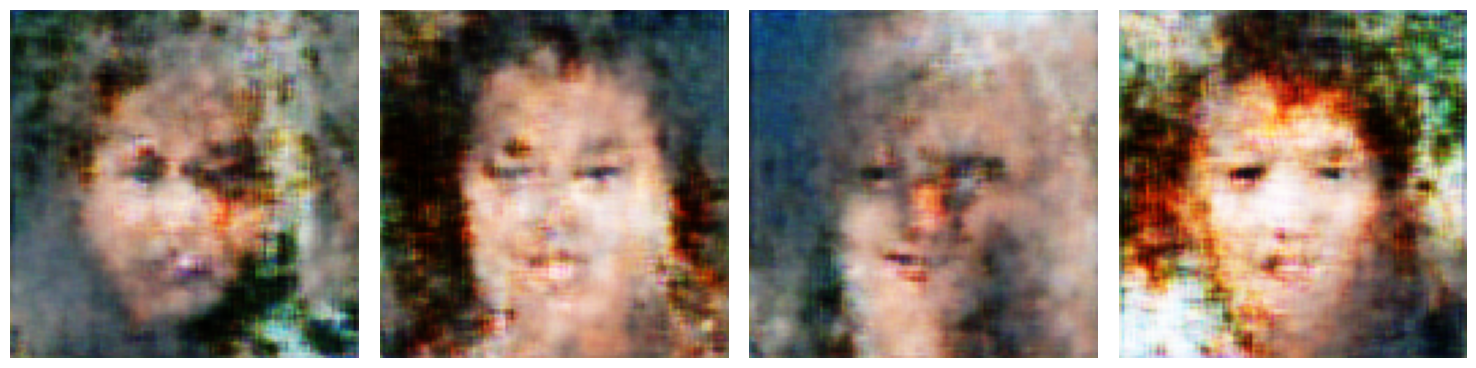

In [44]:
def show_images(generated):
    generated = generated * 0.5 + 0.5

    generated = generated.cpu().detach().numpy()
    generated = np.transpose(generated, (0, 2, 3, 1))

    fig, axes = plt.subplots(1, len(generated), figsize=(15, 5))
    if len(generated) == 1:
        axes = [axes]

    for img, ax in zip(generated, axes):
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

n_images = 4
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = model["generator"](fixed_latent)

show_images(fake_images)

Как вам качество получившихся изображений?

Такое себе качество, но какие никакие лица просматриваются. На большее к сожалению нет ни времени, ни ресурсов

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [58]:
def evaluate_gan_quality(generator, real_dataloader, latent_size=100, device='cuda', max_samples=1000):
    generator.eval()

    real_images = []
    real_count = 0
    for batch, _ in real_dataloader:
        if real_count >= max_samples//2:
            break
        real_images.append(batch.cpu())
        real_count += batch.size(0)
    real_images = torch.cat(real_images, dim=0)[:max_samples//2]

    fake_images = []
    with torch.no_grad():
        for _ in range(0, real_images.size(0), real_dataloader.batch_size):
            batch_size = min(real_dataloader.batch_size, real_images.size(0) - len(fake_images))
            noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images.append(generator(noise).cpu())
    fake_images = torch.cat(fake_images, dim=0)

    X = torch.cat([real_images, fake_images], dim=0)
    X = X.view(X.size(0), -1).numpy()
    y = np.array([1]*real_images.size(0) + [0]*fake_images.size(0))

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X, y)
    predictions = knn.predict(X)
    accuracy = np.mean(predictions == y)

    print(f"1NN accuracy: {accuracy:.4f}")
    return accuracy

In [59]:
accuracy = evaluate_gan_quality(
    model["generator"],
    dataloader,
    latent_size=100,
    device='cuda',
    max_samples=1000
)

1NN accuracy: 1.0000


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Полученный результат говорит о том, что дискриминатор легко отличает настоящие изображения от фейковых. Хотелось бы получить результат, близкий к 0.5, что означало бы, что модель работает отлично.

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

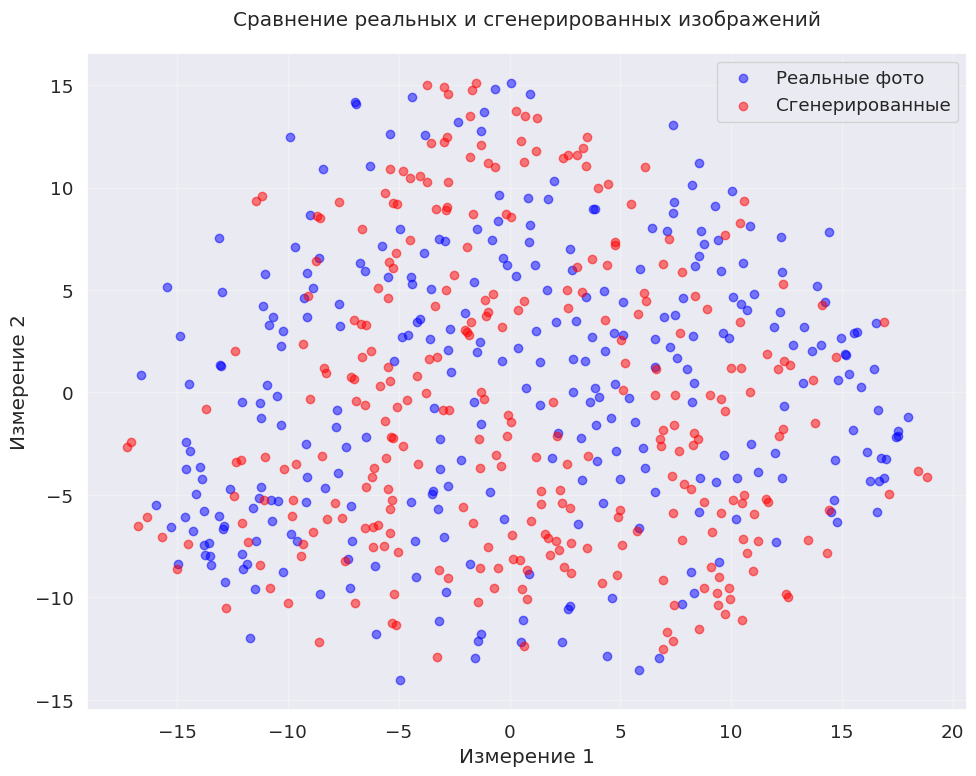

In [66]:
def visualize_distributions(generator, dataloader, latent_size=100, device='cuda', n_samples=300):

    generator.eval()

    real_images = []
    for batch, _ in dataloader:
        real_images.append(batch.cpu())
        if len(torch.cat(real_images, dim=0)) >= n_samples:
            break
    real_images = torch.cat(real_images, dim=0)[:n_samples]

    with torch.no_grad():
        noise = torch.randn(n_samples, latent_size, 1, 1, device=device)
        fake_images = generator(noise).cpu()

    combined_images = torch.cat([real_images, fake_images], dim=0)
    flattened = combined_images.view(combined_images.size(0), -1).numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    points = tsne.fit_transform(flattened)

    plt.figure(figsize=(10, 8), facecolor='white')

    real_points = points[:n_samples]
    fake_points = points[n_samples:]

    plt.scatter(real_points[:, 0], real_points[:, 1],
                c='blue', alpha=0.5, label='Реальные фото')

    plt.scatter(fake_points[:, 0], fake_points[:, 1],
                c='red', alpha=0.5, label='Сгенерированные')

    plt.title('Сравнение реальных и сгенерированных изображений', pad=20)
    plt.xlabel('Измерение 1')
    plt.ylabel('Измерение 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


visualize_distributions(model["generator"], dataloader, latent_size, device)

Прокомментируйте получившийся результат: